# Advanced Vitals Analysis

This notebook demonstrates advanced analysis capabilities for vital signs data using pyCLIF, including filtering, aggregation, visualization, and clinical insights.

## Overview

The vitals table is one of the most important CLIF tables for clinical analysis. This notebook covers:
- Comprehensive vital signs exploration
- Time-series analysis
- Range validation and outlier detection
- Clinical trend analysis
- Statistical summaries and visualizations

## Setup and Imports

In [3]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import pyCLIF components
from pyclif.tables.vitals import vitals
from pyclif.utils.io import load_data

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print(f"Environment setup complete!")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")

Environment setup complete!
Python version: 3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]
Pandas version: 2.3.0
Seaborn version: 0.13.2


In [4]:
# Set data directory
DATA_DIR = "../src/pyclif/data/clif_demo/"
print(f"Data directory: {DATA_DIR}")

Data directory: ../src/pyclif/data/clif_demo/


## Load and Explore Vitals Data

In [5]:
# Load vitals data with timezone conversion
vitals_table = vitals.from_file(DATA_DIR, "parquet")

print(f"✅ Vitals data loaded successfully!")
print(f"Shape: {vitals_table.df.shape}")
print(f"Validation status: {vitals_table.isvalid()}")
print(f"Date range: {vitals_table.df['recorded_dttm'].min()} to {vitals_table.df['recorded_dttm'].max()}")

# Display basic info
print("\nColumn information:")
print(vitals_table.df.info())

Loading clif_vitals.parquet
Data loaded successfully from clif_vitals.parquet
recorded_dttm: null count before conversion= 0
recorded_dttm: Your timezone is UTC, Converting to your site timezone (UTC).
recorded_dttm: null count after conversion= 0
Validation completed with 5 error(s).
  - 5 range validation error(s)
See `errors` and `range_validation_errors` attributes for details.
✅ Vitals data loaded successfully!
Shape: (89085, 6)
Validation status: False
Date range: 2110-04-11 20:52:00+00:00 to 2201-12-13 23:00:00+00:00

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89085 entries, 0 to 89084
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   hospitalization_id  89085 non-null  string             
 1   recorded_dttm       89085 non-null  datetime64[us, UTC]
 2   vital_name          89085 non-null  object             
 3   vital_category      89085 non-n

## Vital Categories Analysis

In [6]:
# Get comprehensive vital categories overview
vital_categories = vitals_table.get_vital_categories()
summary_stats = vitals_table.get_summary_stats()

print(f"=== VITAL CATEGORIES OVERVIEW ===")
print(f"Total vital categories: {len(vital_categories)}")
print(f"Total measurements: {summary_stats['total_records']:,}")
print(f"Unique hospitalizations: {summary_stats['unique_hospitalizations']:,}")

print("\nVital categories available:")
category_counts = summary_stats['vital_category_counts']
for category in sorted(category_counts.keys()):
    count = category_counts[category]
    percentage = (count / summary_stats['total_records']) * 100
    print(f"  {category:<25}: {count:>8,} ({percentage:>5.1f}%)")

=== VITAL CATEGORIES OVERVIEW ===
Total vital categories: 9
Total measurements: 89,085
Unique hospitalizations: 128

Vital categories available:
  dbp                      :   14,351 ( 16.1%)
  heart_rate               :   13,913 ( 15.6%)
  height_cm                :       71 (  0.1%)
  map                      :   14,368 ( 16.1%)
  respiratory_rate         :   13,913 ( 15.6%)
  sbp                      :   14,356 ( 16.1%)
  spo2                     :   13,540 ( 15.2%)
  temp_c                   :    3,767 (  4.2%)
  weight_kg                :      806 (  0.9%)


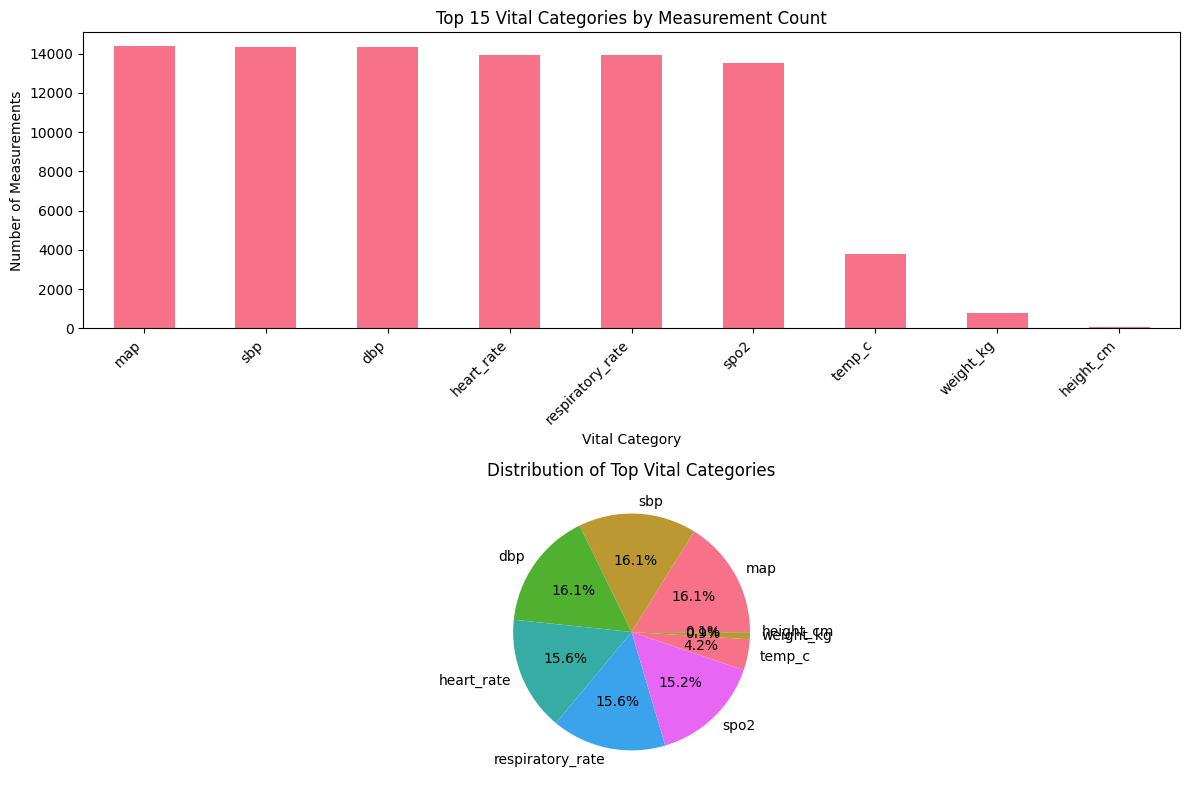

In [7]:
# Visualize vital category distribution
plt.figure(figsize=(12, 8))
category_counts = pd.Series(summary_stats['vital_category_counts'])
top_categories = category_counts.nlargest(15)

plt.subplot(2, 1, 1)
top_categories.plot(kind='bar')
plt.title('Top 15 Vital Categories by Measurement Count')
plt.xlabel('Vital Category')
plt.ylabel('Number of Measurements')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 1, 2)
top_categories.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Top Vital Categories')
plt.ylabel('')

plt.tight_layout()
plt.show()

## Detailed Analysis by Vital Category

In [8]:
# Focus on key vital signs
key_vitals = ['heart_rate', 'sbp', 'dbp', 'temp_c', 'oxygen_saturation', 'respiratory_rate']
available_key_vitals = [v for v in key_vitals if v in vital_categories]

print(f"=== KEY VITAL SIGNS ANALYSIS ===")
print(f"Available key vitals: {available_key_vitals}")

vital_stats_summary = []

for vital in available_key_vitals:
    vital_data = vitals_table.filter_by_vital_category(vital)
    
    if not vital_data.empty and 'vital_value' in vital_data.columns:
        stats = {
            'vital': vital,
            'count': len(vital_data),
            'mean': vital_data['vital_value'].mean(),
            'std': vital_data['vital_value'].std(),
            'min': vital_data['vital_value'].min(),
            'max': vital_data['vital_value'].max(),
            'q25': vital_data['vital_value'].quantile(0.25),
            'q50': vital_data['vital_value'].quantile(0.50),
            'q75': vital_data['vital_value'].quantile(0.75)
        }
        vital_stats_summary.append(stats)
        
        print(f"\n{vital.upper()}:")
        print(f"  Count: {stats['count']:,}")
        print(f"  Mean ± SD: {stats['mean']:.1f} ± {stats['std']:.1f}")
        print(f"  Range: {stats['min']:.1f} - {stats['max']:.1f}")
        print(f"  IQR: {stats['q25']:.1f} - {stats['q75']:.1f}")

# Convert to DataFrame for easier manipulation
vital_stats_df = pd.DataFrame(vital_stats_summary)
print(f"\nSummary statistics calculated for {len(vital_stats_df)} vital signs.")

=== KEY VITAL SIGNS ANALYSIS ===
Available key vitals: ['heart_rate', 'sbp', 'dbp', 'temp_c', 'respiratory_rate']

HEART_RATE:
  Count: 13,913
  Mean ± SD: 91.1 ± 18.7
  Range: 0.0 - 200.0
  IQR: 78.0 - 104.0

SBP:
  Count: 14,356
  Mean ± SD: 114.5 ± 21.0
  Range: 25.0 - 215.0
  IQR: 99.0 - 127.0

DBP:
  Count: 14,351
  Mean ± SD: 61.8 ± 13.5
  Range: 18.0 - 165.0
  IQR: 53.0 - 69.0

TEMP_C:
  Count: 3,767
  Mean ± SD: 37.0 ± 1.9
  Range: 31.1 - 99.0
  IQR: 36.6 - 37.3

RESPIRATORY_RATE:
  Count: 13,913
  Mean ± SD: 20.0 ± 5.6
  Range: 0.0 - 58.0
  IQR: 16.0 - 23.0

Summary statistics calculated for 5 vital signs.


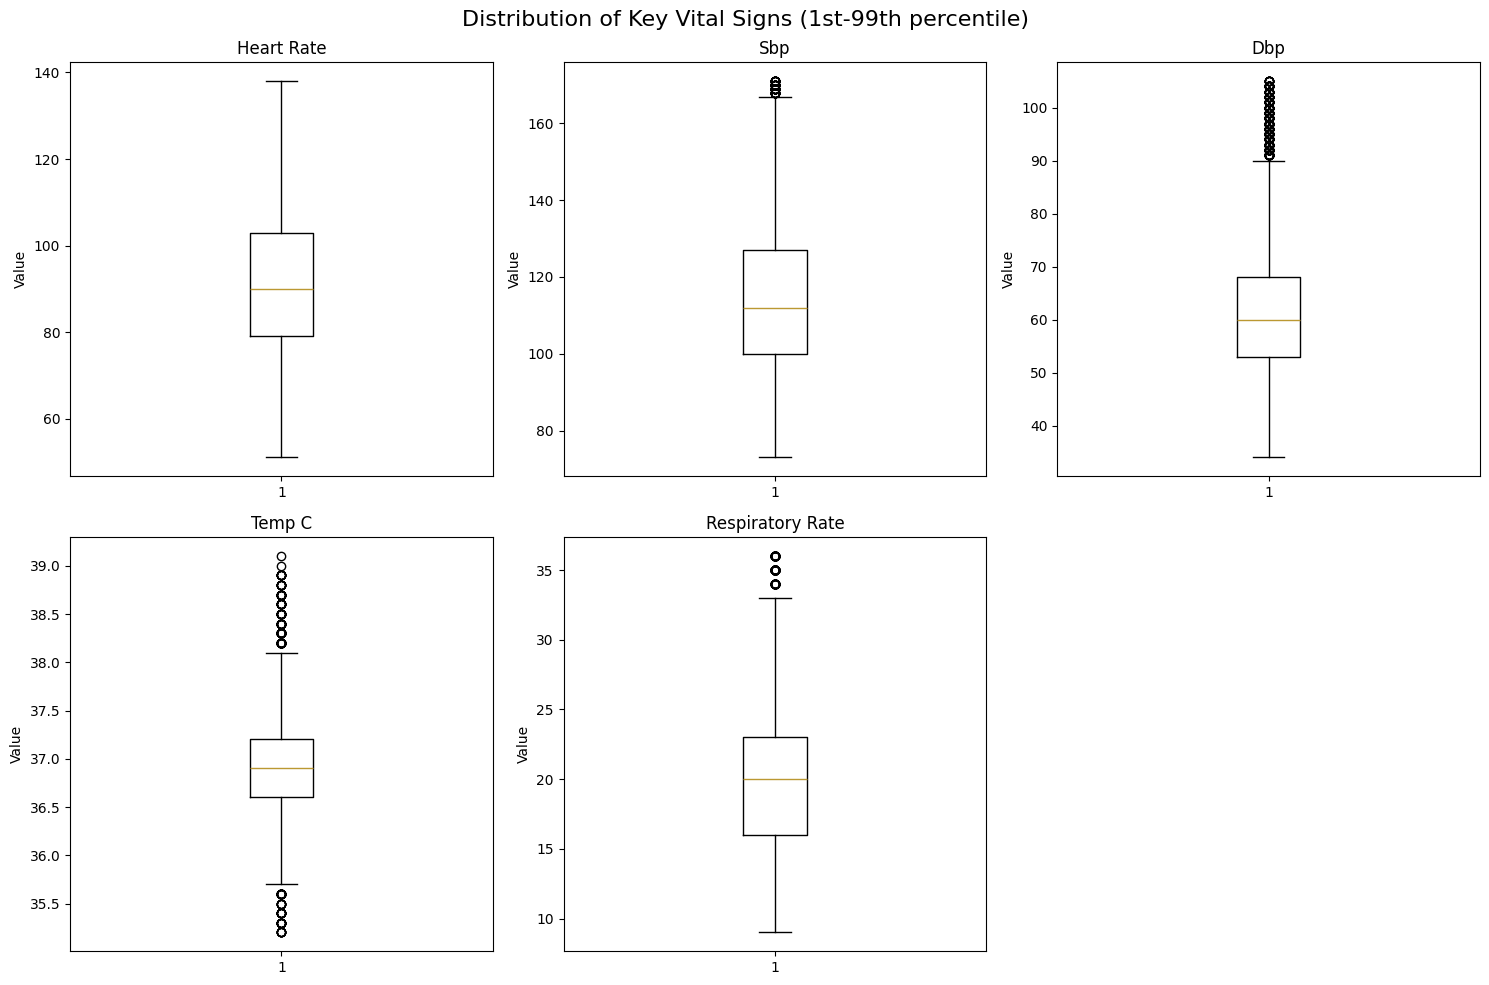

In [9]:
# Create box plots for key vitals
if not vital_stats_df.empty:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, vital in enumerate(available_key_vitals[:6]):
        vital_data = vitals_table.filter_by_vital_category(vital)
        
        if not vital_data.empty and 'vital_value' in vital_data.columns:
            # Remove extreme outliers for visualization
            q1 = vital_data['vital_value'].quantile(0.01)
            q99 = vital_data['vital_value'].quantile(0.99)
            filtered_data = vital_data[
                (vital_data['vital_value'] >= q1) & 
                (vital_data['vital_value'] <= q99)
            ]
            
            axes[i].boxplot(filtered_data['vital_value'])
            axes[i].set_title(f'{vital.replace("_", " ").title()}')
            axes[i].set_ylabel('Value')
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Distribution of Key Vital Signs (1st-99th percentile)', fontsize=16)
    plt.tight_layout()
    plt.show()

## Range Validation and Outlier Analysis

In [10]:
# Analyze range validation results
range_report = vitals_table.get_range_validation_report()

print("=== RANGE VALIDATION ANALYSIS ===")
if not range_report.empty:
    print(f"Total range validation issues: {len(range_report)}")
    
    # Group by error type
    error_type_counts = range_report['error_type'].value_counts()
    print("\nError types:")
    for error_type, count in error_type_counts.items():
        print(f"  {error_type}: {count}")
    
    # Show most problematic vitals
    if 'affected_rows' in range_report.columns:
        problematic_vitals = range_report.groupby('vital_category')['affected_rows'].sum().sort_values(ascending=False)
        print("\nVitals with most range validation issues:")
        for vital, affected_rows in problematic_vitals.head(5).items():
            print(f"  {vital}: {affected_rows:,} affected measurements")
    
    # Display detailed report
    print("\nDetailed range validation report:")
    display_cols = ['vital_category', 'error_type', 'affected_rows', 'message']
    available_cols = [col for col in display_cols if col in range_report.columns]
    print(range_report[available_cols].head(10))
else:
    print("✅ No range validation issues found!")

=== RANGE VALIDATION ANALYSIS ===
Total range validation issues: 5

Error types:
  values_out_of_range: 5

Vitals with most range validation issues:
  map: 14,368 affected measurements
  spo2: 13,540 affected measurements
  temp_c: 3,767 affected measurements
  weight_kg: 806 affected measurements
  height_cm: 71 affected measurements

Detailed range validation report:
  vital_category           error_type  affected_rows  \
0      height_cm  values_out_of_range             71   
1            map  values_out_of_range          14368   
2           spo2  values_out_of_range          13540   
3         temp_c  values_out_of_range           3767   
4      weight_kg  values_out_of_range            806   

                                             message  
0  Vital 'height_cm' has values out of expected r...  
1  Vital 'map' has values out of expected range: ...  
2  Vital 'spo2' has values out of expected range:...  
3  Vital 'temp_c' has values out of expected rang...  
4  Vital 'weight

In [12]:
# Analyze extreme values for a specific vital
def analyze_extreme_values(vital_category, percentile_threshold=0.01):
    """Analyze extreme values for a specific vital category."""
    vital_data = vitals_table.filter_by_vital_category(vital_category)
    
    if vital_data.empty or 'vital_value' not in vital_data.columns:
        print(f"No data available for {vital_category}")
        return
    
    # Calculate percentiles
    low_threshold = vital_data['vital_value'].quantile(percentile_threshold)
    high_threshold = vital_data['vital_value'].quantile(1 - percentile_threshold)
    
    extreme_low = vital_data[vital_data['vital_value'] <= low_threshold]
    extreme_high = vital_data[vital_data['vital_value'] >= high_threshold]
    
    print(f"=== EXTREME VALUES ANALYSIS: {vital_category.upper()} ===")
    print(f"Total measurements: {len(vital_data):,}")
    print(f"Threshold percentiles: {percentile_threshold*100:.1f}% and {(1-percentile_threshold)*100:.1f}%")
    print(f"Low threshold: ≤{low_threshold:.1f} ({len(extreme_low):,} measurements)")
    print(f"High threshold: ≥{high_threshold:.1f} ({len(extreme_high):,} measurements)")

# Analyze extreme values for heart rate
if 'heart_rate' in available_key_vitals:
    analyze_extreme_values('heart_rate')

=== EXTREME VALUES ANALYSIS: HEART_RATE ===
Total measurements: 13,913
Threshold percentiles: 1.0% and 99.0%
Low threshold: ≤51.0 (149 measurements)
High threshold: ≥138.0 (150 measurements)


## Time Series Analysis

=== TEMPORAL ANALYSIS: HEART_RATE ===
Date range: 2110-04-11 20:54:00+00:00 to 2201-12-13 22:00:00+00:00

Daily measurement statistics:
  Mean measurements/day: 0.4
  Max measurements/day: 80
  Days with measurements: 626


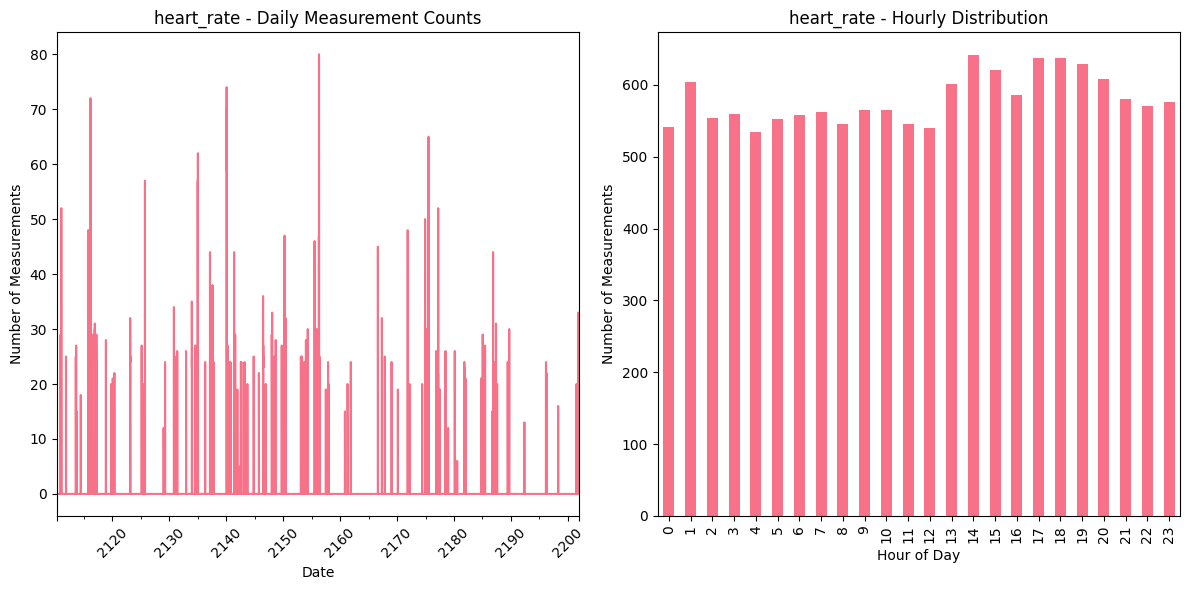

In [13]:
# Analyze temporal patterns in vital signs
def analyze_temporal_patterns(vital_category, sample_patients=5):
    """Analyze temporal patterns for a specific vital category."""
    vital_data = vitals_table.filter_by_vital_category(vital_category)
    
    if vital_data.empty:
        print(f"No data available for {vital_category}")
        return
    
    # Convert datetime column
    vital_data = vital_data.copy()
    vital_data['recorded_dttm'] = pd.to_datetime(vital_data['recorded_dttm'])
    
    print(f"=== TEMPORAL ANALYSIS: {vital_category.upper()} ===")
    print(f"Date range: {vital_data['recorded_dttm'].min()} to {vital_data['recorded_dttm'].max()}")
    
    # Daily measurement counts
    daily_counts = vital_data.set_index('recorded_dttm').resample('D').size()
    print(f"\nDaily measurement statistics:")
    print(f"  Mean measurements/day: {daily_counts.mean():.1f}")
    print(f"  Max measurements/day: {daily_counts.max()}")
    print(f"  Days with measurements: {(daily_counts > 0).sum()}")
    
    # Hourly patterns
    vital_data['hour'] = vital_data['recorded_dttm'].dt.hour
    hourly_counts = vital_data['hour'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    daily_counts.plot()
    plt.title(f'{vital_category} - Daily Measurement Counts')
    plt.xlabel('Date')
    plt.ylabel('Number of Measurements')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    hourly_counts.plot(kind='bar')
    plt.title(f'{vital_category} - Hourly Distribution')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Measurements')
    
    plt.tight_layout()
    plt.show()
    
    return vital_data

# Analyze temporal patterns for available vitals
if available_key_vitals:
    temporal_data = analyze_temporal_patterns(available_key_vitals[0])

## Clinical Insights and Correlations

In [14]:
# Analyze correlations between vital signs
def analyze_vital_correlations(vital_list):
    """Analyze correlations between different vital signs."""
    correlation_data = []
    
    for vital in vital_list:
        vital_subset = vitals_table.filter_by_vital_category(vital)
        if not vital_subset.empty and 'patient_id' in vital_subset.columns:
            # Get average vital value per patient
            patient_avg = vital_subset.groupby('patient_id')['vital_value'].mean().reset_index()
            patient_avg['vital_category'] = vital
            correlation_data.append(patient_avg)
    
    if not correlation_data:
        print("Insufficient data for correlation analysis")
        return
    
    # Combine all vital data
    combined_data = pd.concat(correlation_data, ignore_index=True)
    
    # Pivot to get vitals as columns
    pivot_data = combined_data.pivot(index='patient_id', columns='vital_category', values='vital_value')
    
    # Calculate correlations
    correlations = pivot_data.corr()
    
    print("=== VITAL SIGN CORRELATIONS ===")
    print(f"Patients with complete data: {len(pivot_data.dropna())}")
    print(f"Vitals analyzed: {list(pivot_data.columns)}")
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Matrix of Vital Signs\n(Patient-Level Averages)')
    plt.tight_layout()
    plt.show()
    
    return pivot_data, correlations

# Analyze correlations for available key vitals
if len(available_key_vitals) >= 2:
    vital_correlations = analyze_vital_correlations(available_key_vitals[:4])  # Top 4 vitals

Insufficient data for correlation analysis


## Next Steps and Advanced Usage

This notebook demonstrated:
- Comprehensive vital signs data exploration
- Range validation and outlier detection
- Temporal pattern analysis
- Patient-level vital trends
- Correlation analysis between vitals
- Cohort creation based on vital characteristics
- Clinical insights and summary reporting

### Potential Extensions:
1. **Predictive Modeling**: Use vital trends to predict clinical outcomes
2. **Anomaly Detection**: Identify unusual vital sign patterns
3. **Severity Scoring**: Calculate clinical severity scores (SOFA, APACHE)
4. **Time-to-Event Analysis**: Analyze vital changes before critical events
5. **Multi-Modal Analysis**: Combine vitals with other CLIF tables

### Clinical Applications:
- Early warning systems
- Quality improvement initiatives
- Research on physiological patterns
- Benchmarking and outcome analysis

### Explore Other Notebooks:
- `01_basic_usage.ipynb` - Basic pyCLIF usage
- `02_individual_tables.ipynb` - Individual table classes
- `03_data_validation.ipynb` - Data validation techniques
- `05_timezone_handling.ipynb` - Timezone conversion
- `06_data_filtering.ipynb` - Advanced filtering techniques